# 

In [43]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from matplotlib import colors
from copy import copy

In [44]:
#
# 1D tent function
#
def tent_function(x,i):
    if x<=float(i-1):
        return 0.0
    elif x>float(i+1):
        return 0.0
    elif x<=float(i):
        return x-float(i-1)
    else:
        return float(i+1)-x
#
# Derivative of 1D tent function
#
def dtent_function(x,i):
    if x<=float(i-1):
        return 0.0
    elif x>float(i+1):
        return 0.0
    elif x<=float(i):
        return 1.0
    else:
        return -1.0
#
# Overlap integral of v_i*v_j (assumes i and j are equal or nearest neighbour)
#
def vv_integral(i,j,n):
    if i==j:
        if i==0 or i==n-1:
            return 1.0/3.0
        else:
            return 2.0/3.0
    else:
        return 1.0/6.0
#
# Overlap integral of d_v_i*d_v_j (assumes i and j are equal or nearest neighbour)
#
def dvdv_integral(i,j,n):
    if i==j:
        if i==0 or i==n-1:
            return 1.0
        else:
            return 2.0
    else:
        return -1.0
#
# Overlap integral of d_v_i*v_j (assumes i and j are equal or nearest neighbour)
#
def dvv_integral(i,j,n):
    if i==j:
        if i==0:
            return -1.0/2.0
        elif i==n-1:
            return 1.0/2.0
        else:
            return 0.0
    else:
        if i<j:
            return -1.0/2.0
        else:
            return 1.0/2.0

In [45]:
#
# Define body dimensions in metres and mass density in kg/metre^3 
#
lx=1.0 
ly=0.1
lz=0.01
rho=2710.0 #kg/m3
#
# Define mesh number in x and y directions (must be even)
#
nx=100
ny=20
#
# Define resolution of final displacement fields (for plotting) as a fraction of the mesh sidelengths 
#
plotting_fraction=0.1
#
# Define 2D elasticity (Elastic moduli unit is Pa)
#
bulkModulus=100e9
shearModulus=25e9
bcz=0  #2D plane stress (1 gives 2D plane strain)
#
# Define zero displacement surface boundary conditions
#
bc0=1  #zero displacement on left boundary
bc1=0  #zero traction on lower boundary
bc2=1 #1  #zero disaplacement on right boundary
bc3=0  #zero traction on upper boundary
#
# Scale factor for plotting displacements
#
scaleFactor=50.0 #50.0

In [46]:
#
# Calculate mesh side lengths
#
lx_mesh=lx/float(nx) 
ly_mesh=ly/float(ny)
#
# Define body force as m*g=a**3*rho*g (g=9.8 metres/second**2)
#
bodyForceMagnitude=lx_mesh*ly_mesh*lz*rho*9.8 #as net force in that area
#
# Convert elastic moduli to a force per unit mesh
#
bulkModulus=bulkModulus*lx_mesh*ly_mesh
shearModulus=shearModulus*lx_mesh*ly_mesh
#
# Fix internal variables whose values depend on plane strain or plane stress boundary conditions
#
if bcz==0:
    #
    # Plane stress (slides 27-28)
    #
    m_p=2.0*shearModulus*(6.0*bulkModulus+2.0*shearModulus)/(3.0*bulkModulus+shearModulus)
    m_m=2.0*shearModulus*(6.0*bulkModulus-2.0*shearModulus)/(3.0*bulkModulus+shearModulus)
else:
    #
    # Plane strain (slides 25-26)
    #
    m_p=bulkModulus+4.0*shearModulus/3.0 
    m_m=bulkModulus-2.0*shearModulus/3.0

In [47]:
#
# Define constant matrices and vectors
#
columnSize=2*(nx-bc0-bc2)*(ny-bc1-bc3) #ohne syeros lines und mal zwei wegen 2 dimensions
F=np.zeros(columnSize) #body forces
M=np.zeros((columnSize,columnSize)) # slide 16 for 1D case
Lambda=np.zeros((columnSize,columnSize)) # slide 16 for 1D case
#
# Construct M and Lambda matrices and F column vector
#
for ix in range(bc0,nx-bc2):
    #
    # Check for x-direction boundary conditions
    #
    if ix==bc0:
        djx_m=0
        djx_p=2
    elif ix==nx-bc2-1:
        djx_m=-1
        djx_p=1
    else:
        djx_m=-1
        djx_p=2
    for iy in range(bc1,ny-bc3):
        #
        # Check for y-direction boundary conditions
        #
        if iy==bc1:
            djy_m=0
            djy_p=2
        elif iy==ny-bc3-1:
            djy_m=-1
            djy_p=1
        else:
            djy_m=-1
            djy_p=2
        alpha=(ix-bc0)+(iy-bc1)*(nx-bc0-bc2)
        #
        # Body force column vector
        #
        F[2*alpha]=0.0
        F[2*alpha+1]=bodyForceMagnitude
        #
        # Matrices
        #
        for djx in range(djx_m,djx_p):
            for djy in range(djy_m,djy_p):
                jx=ix+djx
                jy=iy+djy
                beta=(jx-bc0)+(jy-bc1)*(nx-bc0-bc2)
                #
                # Diagonal M matrix
                #
                M[2*alpha,2*beta]=vv_integral(ix,jx,nx)*vv_integral(iy,jy,ny)
                M[2*alpha+1,2*beta+1]=vv_integral(ix,jx,nx)*vv_integral(iy,jy,ny)
                #
                # Lambda Matrix
                #
                Lambda[2*alpha,2*beta]=m_p*dvdv_integral(ix,jx,nx)*vv_integral(iy,jy,ny)+shearModulus*vv_integral(ix,jx,nx)*dvdv_integral(iy,jy,ny)
                Lambda[2*alpha,2*beta+1]=m_m*dvv_integral(ix,jx,nx)*dvv_integral(jy,iy,ny)+shearModulus*dvv_integral(jx,ix,nx)*dvv_integral(iy,jy,ny)
                Lambda[2*alpha+1,2*beta]=shearModulus*dvv_integral(ix,jx,nx)*dvv_integral(jy,iy,ny)+m_m*dvv_integral(jx,ix,nx)*dvv_integral(iy,jy,ny)    
                Lambda[2*alpha+1,2*beta+1]=m_p*dvdv_integral(iy,jy,ny)*vv_integral(ix,jx,nx)+shearModulus*dvdv_integral(ix,jx,nx)*vv_integral(iy,jy,ny)

In [48]:
#
# Solve static displacement problem
#
U=np.zeros(columnSize) #displacement coefficients
U=-np.matmul(inv(Lambda),np.matmul(M,F))

In [49]:
#
# Calculate displacement field of 2D solid
#
ux=np.zeros((nx,ny)) 
uy=np.zeros((nx,ny))
x0=[]
y0=[]
x=[]
y=[]
for ix in range(bc0,nx-bc2):
    for iy in range(bc1,ny-bc3):
        alpha=(ix-bc0)+(iy-bc1)*(nx-bc0-bc2)
        ux[ix,iy]=U[2*alpha]
        uy[ix,iy]=U[2*alpha+1]
        x0.append(ix*lx_mesh)
        y0.append(iy*ly_mesh)
        x.append(ix*lx_mesh+scaleFactor*U[2*alpha])
        y.append(iy*ly_mesh+scaleFactor*U[2*alpha+1])
#
# Calculate fine grained displacement field and strain
#
pnx=nx*9
pny=ny*9
#
# Displacement field
#
pux=np.zeros((pnx,pny))
puy=np.zeros((pnx,pny))
for ix in range(bc0,nx-bc2):
    for iy in range(bc1,ny-bc3):
        alpha=(ix-bc0)+(iy-bc1)*(nx-bc0-bc2)
        for pix in range(-10,11):
            px=10*ix+pix
            if px<1: continue
            if px>pnx-1: continue
            for piy in range(-10,11):
                py=10*iy+piy
                if py<1: continue
                if py>pny-1: continue
                pux[px,py]+=U[2*alpha]*tent_function(float(px)/10.0,ix)*tent_function(float(py)/10.0,iy)
                puy[px,py]+=U[2*alpha+1]*tent_function(float(px)/10.0,ix)*tent_function(float(py)/10.0,iy)
#
# Strain field (derived from tent functions)
#
pexx=np.zeros((pnx,pny))
peyy=np.zeros((pnx,pny))
pexy=np.zeros((pnx,pny))
for ix in range(bc0,nx-bc2):
    for iy in range(bc1,ny-bc3):
        alpha=(ix-bc0)+(iy-bc1)*(nx-bc0-bc2)        
        for pix in range(-10,11):
            px=10*ix+pix
            if px<1: continue
            if px>pnx-1: continue
            for piy in range(-10,11):
                py=10*iy+piy
                if py<1: continue
                if py>pny-1: continue
                pexx[px,py]+=U[2*alpha]*dtent_function(float(px)/10.0,ix)*tent_function(float(py)/10.0,iy)/lx_mesh
                peyy[px,py]+=U[2*alpha+1]*tent_function(float(px)/10.0,ix)*dtent_function(float(py)/10.0,iy)/ly_mesh
                pexy[px,py]+=(U[2*alpha]*tent_function(float(px)/10.0,ix)*dtent_function(float(py)/10.0,iy)/ly_mesh+
                                            U[2*alpha+1]*dtent_function(float(px)/10.0,ix)*tent_function(float(py)/10.0,iy)/lx_mesh)/2.0


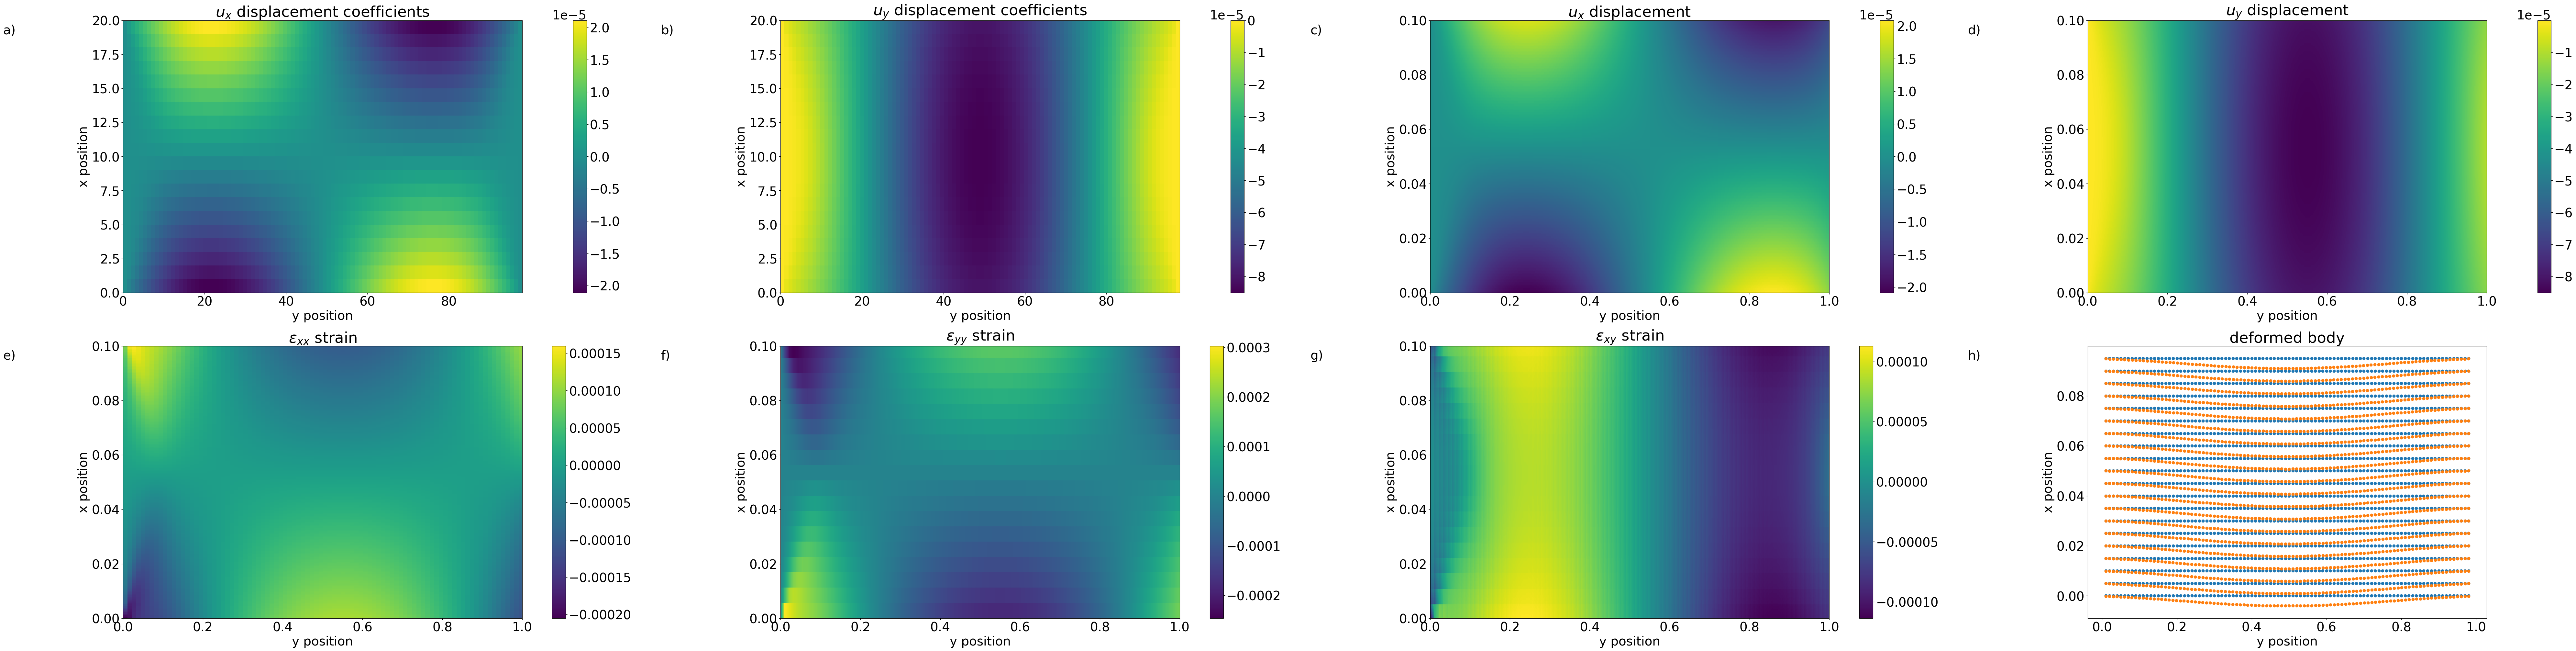

In [50]:
plt.rcParams.update({'font.size': 28})
#
# Plot data
#
fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(2,4)
panel00 = fig.add_subplot(gs[0,0])
panel01 = fig.add_subplot(gs[0,1])
panel10 = fig.add_subplot(gs[0,2])
panel11 = fig.add_subplot(gs[0,3])
panel20 = fig.add_subplot(gs[1,0])
panel21 = fig.add_subplot(gs[1,1])
panel30 = fig.add_subplot(gs[1,2])
panel31 = fig.add_subplot(gs[1,3])

panel00.set_title(r'$u_{x}$ displacement coefficients')
panel00.set_xlabel(r'y position')
panel00.set_ylabel(r'x position')
p00=panel00.imshow(np.transpose(ux),extent=(0,nx-bc0-bc2,0,ny-bc1-bc3),aspect='auto',origin='lower',interpolation='none')  
plt.colorbar(p00)
panel00.text(-0.3,0.95,'a)',transform=panel00.transAxes)

panel01.set_title(r'$u_{y}$ displacement coefficients')
panel01.set_xlabel(r'y position')
panel01.set_ylabel(r'x position')
p01=panel01.imshow(np.transpose(uy),extent=(0,nx-bc0-bc2,0,ny-bc1-bc3),aspect='auto',origin='lower',interpolation='none')  
plt.colorbar(p01)
panel01.text(-0.3,0.95,'b)',transform=panel01.transAxes)

panel10.set_title(r'$u_{x}$ displacement')
panel10.set_xlabel(r'y position')
panel10.set_ylabel(r'x position')
p10=panel10.imshow(np.transpose(pux[1:pnx-1,1:pny-1]),extent=(0,lx,0,ly),aspect='auto',origin='lower',interpolation='none')  
plt.colorbar(p10)
panel10.text(-0.3,0.95,'c)',transform=panel10.transAxes)

panel11.set_title(r'$u_{y}$ displacement')
panel11.set_xlabel(r'y position')
panel11.set_ylabel(r'x position')
p11=panel11.imshow(np.transpose(puy[1:pnx-1,1:pny-1]),extent=(0,lx,0,ly),aspect='auto',origin='lower',interpolation='none')  
plt.colorbar(p11)
panel11.text(-0.3,0.95,'d)',transform=panel11.transAxes)

panel20.set_title(r'$\varepsilon_{xx}$ strain')
panel20.set_xlabel(r'y position')
panel20.set_ylabel(r'x position')
p20=panel20.imshow(np.transpose(pexx[1:pnx-1,1:pny-1]),extent=(0,lx,0,ly),aspect='auto',origin='lower',interpolation='none')  
plt.colorbar(p20)
panel20.text(-0.3,0.95,'e)',transform=panel20.transAxes)

panel21.set_title(r'$\varepsilon_{yy}$ strain')
panel21.set_xlabel(r'y position')
panel21.set_ylabel(r'x position')
p21=panel21.imshow(np.transpose(peyy[1:pnx-1,1:pny-1]),extent=(0,lx,0,ly),aspect='auto',origin='lower',interpolation='none')  
plt.colorbar(p21)
panel21.text(-0.3,0.95,'f)',transform=panel21.transAxes)

panel30.set_title(r'$\varepsilon_{xy}$ strain')
panel30.set_xlabel(r'y position')
panel30.set_ylabel(r'x position')
p30=panel30.imshow(np.transpose(pexy[2:pnx-2,2:pny-2]),extent=(0,lx,0,ly),aspect='auto',origin='lower',interpolation='none')  
plt.colorbar(p30)
panel30.text(-0.3,0.95,'g)',transform=panel30.transAxes)

panel31.set_title(r'deformed body')
panel31.set_xlabel(r'y position')
panel31.set_ylabel(r'x position')
panel31.scatter(x0,y0)
panel31.scatter(x,y)
panel31.text(-0.3,0.95,'h)',transform=panel31.transAxes)

fig.set_figheight(20)
fig.set_figwidth(80)
plt.show()
